# PK Modelling Project - Mirtazapine
Using Non-linear kinetics to better match sample data

Updated settings

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
#sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution, shgo, basinhopping

np.set_printoptions(suppress=True)

In [2]:
# Graph settings
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Neue Einstellung'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
mpl.rc('axes', titlesize=18, titleweight=20, labelsize=14, facecolor=[0.9,0.9,0.9], edgecolor=[0.5, 0.5, 0.5], linewidth=0.5)
mpl.rc('xtick', labelsize=12, color=[0.3,0.3,0.3])
mpl.rc('ytick', labelsize=12)
mpl.rc('lines', linewidth=3, markersize=10)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', axisbelow=True)
savefigOpts = {'dpi': 100, 'transparent': True}

#font_dirs = [r'C:\Users\klty0\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
font_dirs = [r'C:\Users\Kenneth Leung\Dropbox\Holmusk\Holmusk Templates\Fonts', ]
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = mpl.font_manager.createFontList(font_files)
mpl.font_manager.fontManager.ttflist.extend(font_list)

In [3]:
color_scheme = ['#11151D', '#3360CC', '#77B55B'] #Black, Blue, Green

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [4]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
    [50,1,27.5,7.4],
    [51,0,27.8,5.8]
]

In [5]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','female','age_mean','age_sd'])

In [6]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference, Freq, Dose, Number of prior doses)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
]

In [7]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])

In [8]:
df_subject_master = df_pk_paras.merge(df_attr, on = 'subject_id')
df_subject_master['V1'] = [152 if x == 'Single' else 107 for x in df_subject_master['dosing']]
df_subject_master

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose,female,age_mean,age_sd,V1
0,1,32.3,11.4,1.65,0.70,345,103,20,Single,15,0,24.0,4.0,152
1,2,32.5,9.7,1.50,0.60,281,83,21,Single,15,0,25.0,5.0,152
2,3,31.6,12.8,1.82,0.71,216,46,22,Single,15,0,25.0,4.0,152
3,4,42.5,16.3,1.20,0.30,362,66,23,Single,15,0,51.0,8.0,152
4,5,40.6,13.8,1.45,0.73,486,161,24,Single,15,0,68.0,5.0,152
5,6,32.1,8.1,1.67,0.65,355,199,25,Single,20,0,33.0,6.0,152
6,7,48.4,20.1,1.59,0.74,647,294,25,Single,20,0,69.0,3.0,152
7,8,67.7,20.6,1.04,0.10,459,136,26,Single,30,0,21.0,1.0,152
8,9,74.4,23.5,1.41,0.74,614,177,27,Single,30,0,23.0,4.0,152
9,10,56.1,13.9,1.42,0.56,562,134,28,Single,30,0,27.0,9.0,152


#### Read in real data (from literature)

In [9]:
path = '.\Samples\Multiple Dosing'
files = os.listdir(path)
files_xls = [f for f in files if f[-4:] == 'xlsx']

In [10]:
files_xls

['subject19_ref31_15mg_mod.xlsx',
 'subject20_ref22_mod.xlsx',
 'subject22_ref25_adults_males_multi_20mg_mod.xlsx',
 'subject23_ref25_elderly_males_multi_20mg_mod.xlsx',
 'subject25_ref33_30mg_mod.xlsx',
 'subject26_ref31_30mg_mod.xlsx',
 'subject33_ref31_45mg_mod.xlsx',
 'subject36_ref31_60mg_mod.xlsx',
 'subject37_ref31_75mg_mod.xlsx',
 'subject39_ref25_adults_females_multi_20mg_mod.xlsx',
 'subject40_ref25_elderly_females_multi_20mg_mod.xlsx']

In [11]:
list_of_raw_df = []

for file in files_xls:
    data = pd.read_excel(f'./Samples/Multiple Dosing/{file}')
    df = pd.DataFrame(data)
    df['time'] = round(df['time'],3)   
    list_of_raw_df.append(df)

In [12]:
# 11 cohort subjects (multi dosing) with real raw time-conc data
subject_id_list = [19,20,22,23,25,26,33,36,37,39,40]

In [13]:
prior_doses = [5,7,7,7,7,5,5,5,5,7,7]
five_prior_doses = [19,26,33,36,37]
seven_prior_doses = [20,22,23,25,39,40]

In [14]:
subject_prior_doses = dict(zip(subject_id_list, prior_doses))

In [15]:
list_of_samples = dict(zip(subject_id_list, list_of_raw_df))

In [16]:
# Adjusting the time points based on the number of prior doses received (for multiple dosing)
for i in list_of_samples:
    if i in five_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 96
    if i in seven_prior_doses:
        list_of_samples[i]['time'] = list_of_samples[i]['time'] + 144
#     if i in six_prior_doses:
#         list_of_samples[i]['time'] = list_of_samples[i]['time'] + 120

In [17]:
for i in list_of_samples:  
    if list_of_samples[i]['time'][0] != 0.0:
        new_row = pd.DataFrame({'time':0.0, 'conc':0.0}, index =[0])
        list_of_samples[i] = pd.concat([new_row, list_of_samples[i][:]]).reset_index(drop = True)
    else:
        pass

In [18]:
list_of_samples

{19:       time       conc
 0     0.00   0.000000
 1    96.00   7.229920
 2    96.25   7.479224
 3    96.50   9.972299
 4    96.75  18.199400
 5    97.00  22.936288
 6    97.50  30.664820
 7    98.00  32.409972
 8    99.00  30.466205
 9   100.00  27.175208
 10  101.00  24.681400
 11  102.00  21.689751
 12  104.00  19.944598
 13  107.00  15.955679
 14  111.00  12.465374
 15  120.00   7.977839,
 20:        time      conc
 0     0.000   0.00000
 1   144.000   4.01301
 2   144.500   6.48849
 3   144.750  18.38440
 4   145.000  38.42020
 5   145.250  53.25850
 6   145.375  50.84170
 7   145.500  47.35920
 8   146.000  32.99720
 9   146.500  24.93080
 10  147.000  21.09790
 11  148.000  15.25170
 12  149.000  14.47360
 13  151.000  12.35130
 14  153.000   9.22670
 15  156.000   5.85692
 16  160.000   6.14909
 17  168.000   4.08384
 18  180.000   1.42717
 19  192.000   1.09918
 20  204.000   0.60920,
 22:       time       conc
 0     0.00   0.000000
 1   144.00   7.178751
 2   144.25   7.6173

#### Generate dataframe and reformat into clearer columns

In [19]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[3])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

## Fixing KM

#### Multiple Dosing

In [20]:
# Initial parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (inclusive of GI tract)

In [21]:
V1_multi = 107 # Central volume of distribution for multiple dosing

In [22]:
all_time_points = [0,24,48,72,96,120,144,168]

In [23]:
def dC(t, C, ka, Bmax_k12, k21, ke, KM):
    
    A, C1, C2 = C[0], C[1], C[2]
    
    dC0dt = -ka*A
    dC1dt = (ka*(A/V1_multi)) - (Bmax_k12*(C1/(KM + C1))) + k21*C2 - ke*C1
    dC2dt = (Bmax_k12*(C1 / (KM + C1))) - k21*C2

    dCdt = np.array([[dC0dt],[dC1dt],[dC2dt]]).reshape(n,)
    
    return dCdt

In [24]:
def ode_solver(p, subject_id, period_start, period_end, C_initial):
    
    ka, Bmax_k12, k21, ke = p
    KM = 14.3

    intervals = ((period_end - period_start) * 8) + 1
    
    time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

In [44]:
def objective_func(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    t_horizon = []
    
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
        
    output_dict = dict(zip(t_horizon, central_conc))

    sample_df = list_of_samples[subject_id]
    t_sample = sample_df['time'].values
    y_pred = [output_dict[t] for t in t_sample] 
    y_actual = sample_df['conc'].values
    
    error = y_actual - y_pred
    normalized_error = error / y_actual.max()
    squared_error = np.power(normalized_error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]

    Cmax_pred = np.amax(output.y[1])
    Cmax_pred_index = np.where(output.y[1] == Cmax_pred)[0][0]
    Tmax_pred = output.t[Cmax_pred_index]
    Cmax_actual = sample_df['conc'].max()
    Tmax_actual = sample_df.iloc[sample_df['conc'].argmax(), :1].values[0]
    Cmax_diff = np.abs(Cmax_actual - Cmax_pred)
    Tmax_diff = np.abs(Tmax_actual - Tmax_pred)
    Cmax_limit = 0.04 * Cmax_actual # Allow up to 4% variation
    Tmax_limit = 0.04 * Tmax_actual
    if Cmax_diff < Cmax_limit:
        Cmax_penalty = Cmax_diff
        Tmax_penalty = Tmax_diff
    else:
        Cmax_penalty = np.square(Cmax_diff)
        Tmax_penalty = np.square(Tmax_diff)
    total_penalty = Cmax_penalty + Tmax_penalty
    total_error = mse + (0.001 * total_penalty) # Add weights
    return total_error

In [26]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
    
    # Setup timepoints
    time_points = all_time_points[:subject_prior_doses[subject_id]] # Add the dosing time points
    final_timepoint = int(list_of_samples[subject_id]['time'].values[-1]) # Final data timepoint where trajectory ends
    time_points.append(final_timepoint)
    n_timepoints = len(time_points)
    
    # Initial concentration
    dose_mg = df_subject_master[df_subject_master.subject_id == subject_id]['dose'].values[0]   
    dose_ug = dose_mg * 1000   
    
    C_initial = np.zeros(n)
    C_initial.reshape(n,)
    C_initial[0] = (dose_ug * F)
    C_initial[1] = list_of_samples[subject_id]['conc'][0]
    
    central_conc = []
    peripheral_conc = []
    t_horizon = []
    
    for i in range(1,n_timepoints):
        period_start = time_points[i-1]
        period_end = time_points[i]

        output = ode_solver(p, subject_id, period_start, period_end, C_initial)
        
        central_conc = np.append(central_conc,output.y[1])
        peripheral_conc = np.append(peripheral_conc,output.y[2])
        t_horizon = np.append(t_horizon, output.t)
        
        C_initial[0] = output.y[0][-1] + (dose_ug*F)
        C_initial[1] = output.y[1][-1]
        C_initial[2] = output.y[2][-1]
    
    plt.figure(figsize=(10,5))
    plt.xlabel('Time (h)')
    plt.ylabel('Plasma concentration (ug/L)')
    plt.title(f'Cohort ID = {subject_id}')
    plt.plot(t_horizon,central_conc, color = color_scheme[1], label = 'Central concentration')
    #plt.plot(t_horizon,peripheral_conc, color = color_scheme[2], label = 'Peripheral concentration')
    print(f'Central Cmax = {np.amax(output.y[1])}, Peripheral Cmax = {np.amax(output.y[2])}')
    plt.legend()
    plt.scatter(list_of_samples[subject_id]['time'], list_of_samples[subject_id]['conc'], color = color_scheme[0], s = 25)
    #plt.savefig(f'./Images/15 Raw Trajectories/Subject ID {subject_id}.png', **savefigOpts)

In [27]:
#  ka, Bmax_k12, k21, ke
bounds = [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]

In [28]:
de_results_multi = []

for subject_id in subject_id_list:
        start = time.perf_counter()
        best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 16,
                                             recombination=0.8, mutation = (0,1), maxiter = 1000, tol = 0.0003,
                                             args = (subject_id,), seed = 42)
        de_results_multi.append([subject_id, best_result.x, best_result.fun, bounds])
        
        finish = time.perf_counter()
        print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
        print(best_result.x, best_result.fun)
        print(f'Bounds: {bounds}')

19 DE completed in 60.59 seconds
[ 0.42082112 13.12185222  0.24095931  0.19240613] 0.009454835442085486
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
20 DE completed in 263.42 seconds
[ 2.06644835 20.20483324  0.02177025  0.1434584 ] 0.05161437480899857
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
22 DE completed in 79.63 seconds
[ 0.69149947 37.28058139  0.31221163  0.2627501 ] 0.010788391569888589
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
23 DE completed in 127.16 seconds
[ 0.27485669 31.15085351  0.15756533  0.1447959 ] 0.011760181038802895
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
25 DE completed in 88.12 seconds
[ 0.50310006 32.33967157  0.2143197   0.25835763] 0.013868299424981224
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
26 DE completed in 78.45 seconds
[ 0.4021467  29.08564715  0.24382626  0.17141837] 0.009188733182823391
Bounds: [(0.1, 2.4), (2.0, 75.0), (0.01, 0.7), (0.07, 0.4)]
33 DE completed

Central Cmax = 32.097987333655986, Peripheral Cmax = 31.98736383509222
Central Cmax = 51.12840739759647, Peripheral Cmax = 292.0899245053449
Central Cmax = 39.220068825781325, Peripheral Cmax = 71.41776761757157
Central Cmax = 42.6094799252533, Peripheral Cmax = 134.2986997858864
Central Cmax = 57.8517997865002, Peripheral Cmax = 100.27293710039096
Central Cmax = 68.06094219895137, Peripheral Cmax = 89.87741846130514
Central Cmax = 97.22992825775316, Peripheral Cmax = 134.74592844894724
Central Cmax = 128.89426493696476, Peripheral Cmax = 316.3474492728441
Central Cmax = 151.08033267161892, Peripheral Cmax = 453.1614668299446
Central Cmax = 48.765438150478616, Peripheral Cmax = 172.43289003005188


findfont: Font family ['Neue Einstellung'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Neue Einstellung'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Neue Einstellung'] not found. Falling back to DejaVu Sans.


Central Cmax = 52.88888857351383, Peripheral Cmax = 243.8219103563934


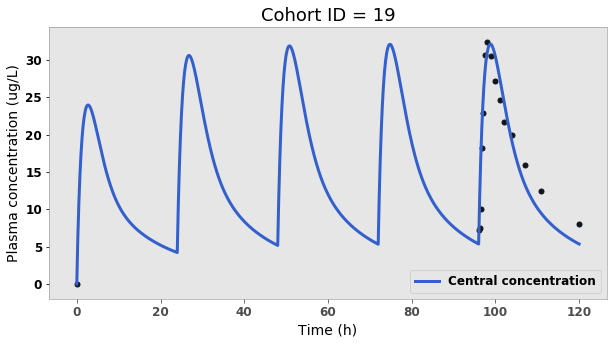

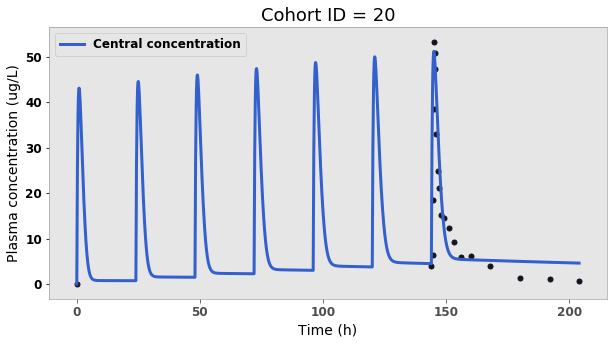

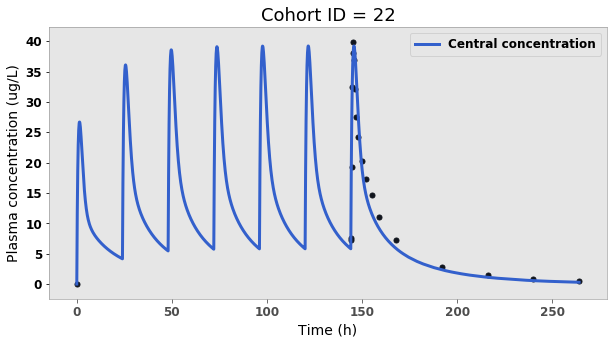

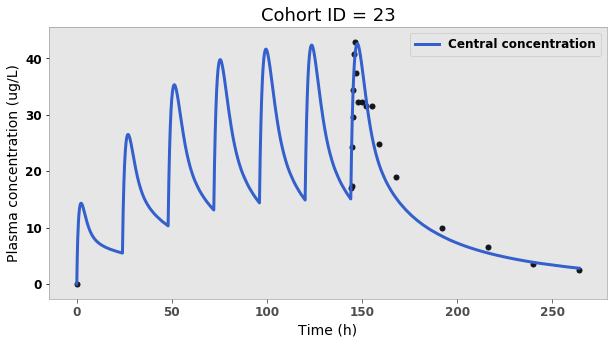

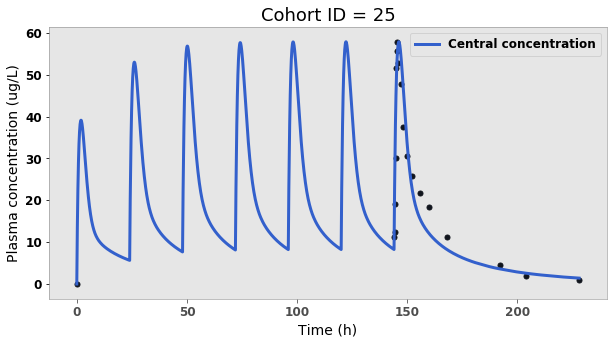

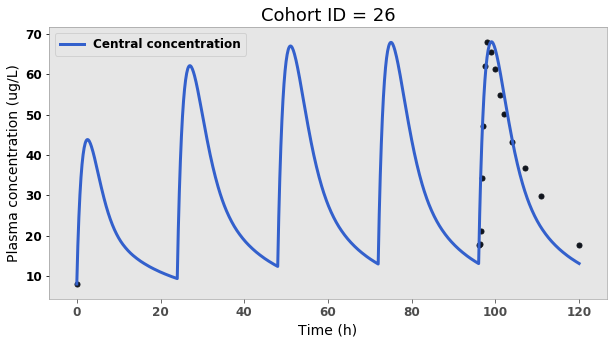

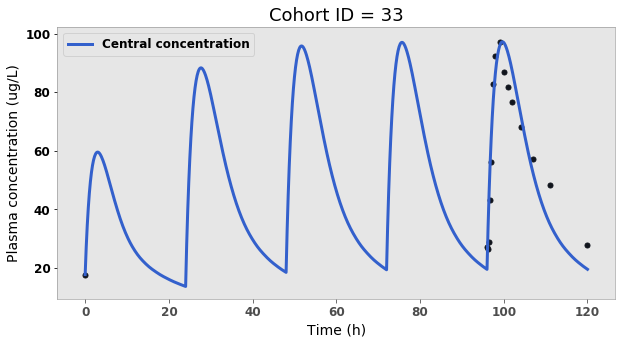

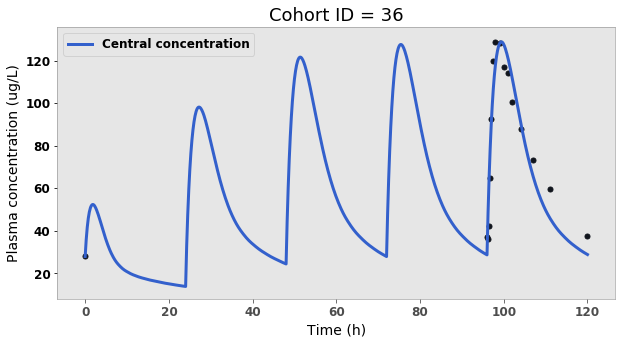

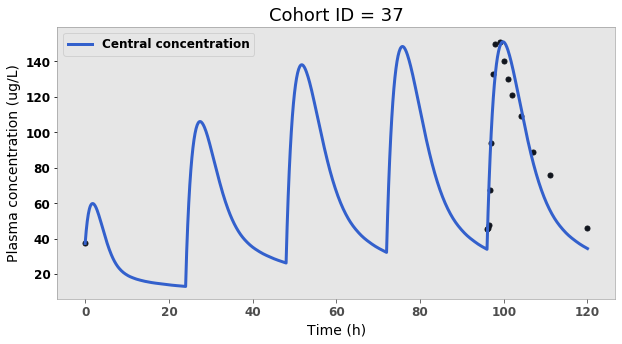

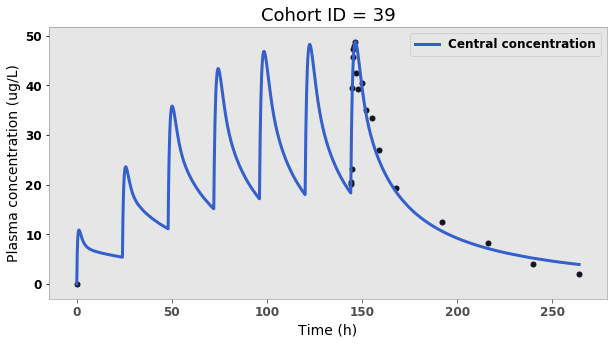

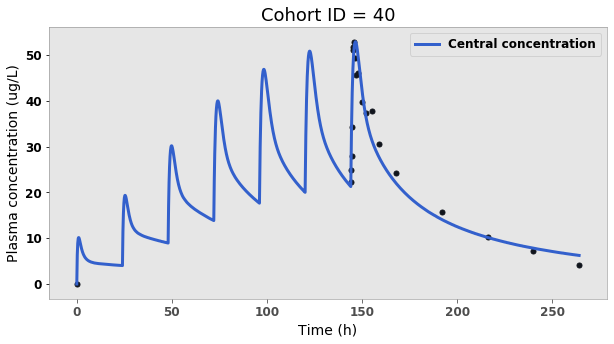

In [29]:
# KM = 14.3
df_multi = format_de_dataframe(de_results_multi)
for subject_id in df_multi.subject_id.values:
    k_values = list(df_multi[df_multi.subject_id == subject_id][['ka','Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)

#### Export k values

In [45]:
#df_multi.to_excel('Final k values V3 (Multiple Dosing).xlsx', index = None)

___
### NOT USED
### Fix ka

In [63]:
def ode_solver(p, subject_id, period_start, period_end, C_initial):
    
    Bmax_k12, k21, ke = p
    KM = 14.3
    ka = 0.85

    intervals = ((period_end - period_start) * 8) + 1
    
    time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=3)

    output = solve_ivp(fun=dC, t_span=[period_start, period_end], t_eval = time_horizon, 
                       y0 = C_initial, args=(ka, Bmax_k12, k21, ke, KM,))
    return output

In [49]:
def format_de_dataframe(de):
    df_de_results = pd.DataFrame(de, columns = ['subject_id', 'k_values', 'error', 'bounds'])
    df_de_results.loc[:, 'ka'] = 0.85
    df_de_results.loc[:, 'Bmax_k12'] = df_de_results['k_values'].map(lambda x: x[0])
    df_de_results.loc[:, 'k21'] = df_de_results['k_values'].map(lambda x: x[1])
    df_de_results.loc[:, 'ke'] = df_de_results['k_values'].map(lambda x: x[2])
    df_de_results.loc[:, 'KM'] = 14.3
    df_de_results.drop(columns = 'k_values')
    df_de_results_final = df_de_results.merge(df_subject_master, on = 'subject_id')
    return df_de_results_final

In [40]:
#  Bmax_k12, k21, ke
bounds = [(50, 140.0), (0.01, 30), (0.01, 8)]

In [41]:
de_results_multi = []

for subject_id in subject_id_list:
    start = time.perf_counter()
    
    best_result = differential_evolution(objective_func, bounds, strategy='best2bin', popsize = 15,
                                         recombination=0.8, mutation = (0,1), maxiter = 1000, tol = 0.0004,
                                         args = (subject_id,), seed = 42)
    
    de_results_multi.append([subject_id, best_result.x, best_result.fun, bounds])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)
    print(f'Bounds: {bounds}')

19 DE completed in 189.84 seconds
[139.99030892   3.18015704   0.20405493] 0.011371611572822541
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
20 DE completed in 803.88 seconds
[50.02533695 29.99627988  0.13478073] 0.09186597739422044
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
22 DE completed in 303.45 seconds
[50.02623801  0.46181219  0.26881929] 0.011598167913497777
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
23 DE completed in 256.82 seconds
[139.9572114    1.4487387    0.17622057] 0.024065541799340992
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
25 DE completed in 265.86 seconds
[139.99907577   2.23422197   0.29339737] 0.016214862714131983
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
26 DE completed in 102.92 seconds
[139.99934032   1.66824602   0.20197494] 0.019776385130603914
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
33 DE completed in 155.65 seconds
[139.93959405   1.304882     0.24514627] 0.04755135640890127
Bounds: [(50, 140.0), (0.01, 30), (0.01, 8)]
36 DE completed in 12

Central Cmax = 32.4099626027047, Peripheral Cmax = 30.46667435782164
Central Cmax = 51.128593941748925, Peripheral Cmax = 1.3037994973070797
Central Cmax = 39.26440925173102, Peripheral Cmax = 67.56795247245833
Central Cmax = 42.933185116871684, Peripheral Cmax = 71.65162049042506
Central Cmax = 57.85180044133927, Peripheral Cmax = 49.883347243952755
Central Cmax = 68.06094211640324, Peripheral Cmax = 68.76105342863933
Central Cmax = 97.33192352905324, Peripheral Cmax = 92.0384035413008
Central Cmax = 128.8942664860847, Peripheral Cmax = 118.37682033465457
Central Cmax = 151.0816979339571, Peripheral Cmax = 126.18482979638267
Central Cmax = 48.765438204892774, Peripheral Cmax = 115.04757550537812
Central Cmax = 52.8888643042008, Peripheral Cmax = 145.59771063726402


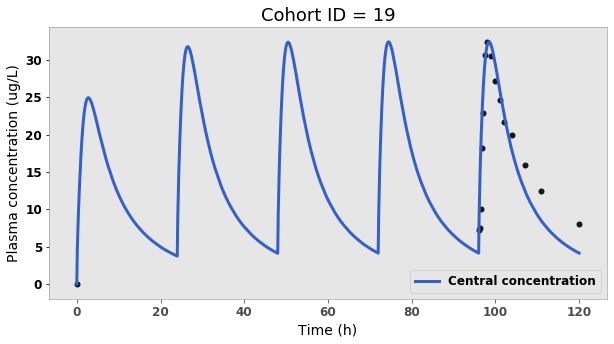

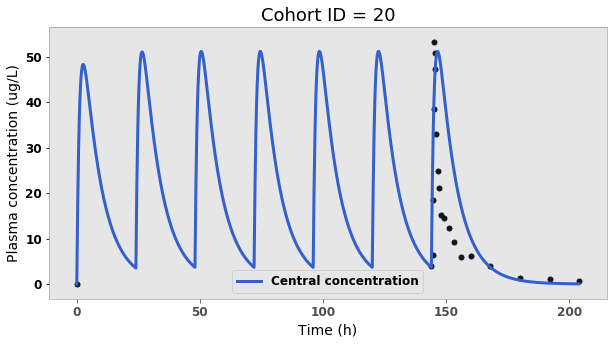

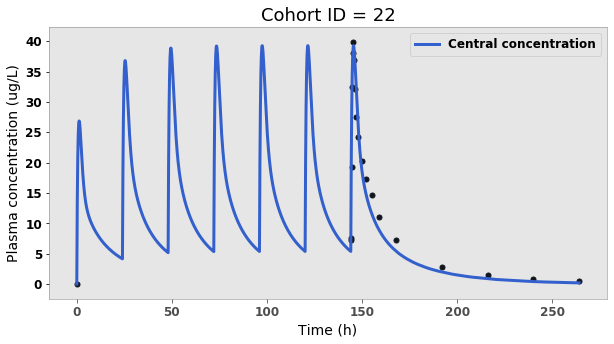

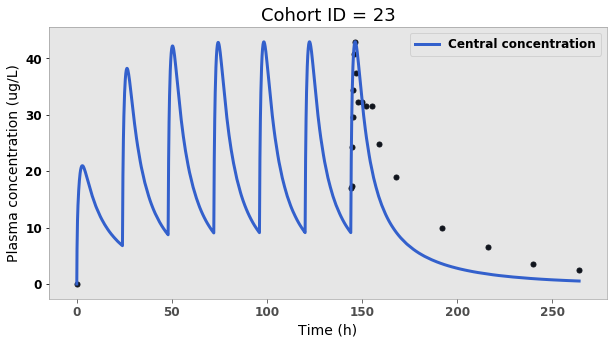

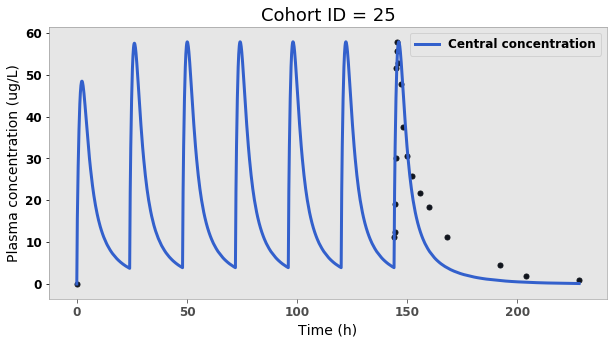

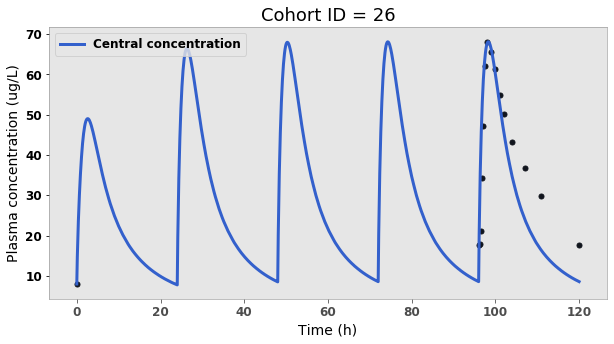

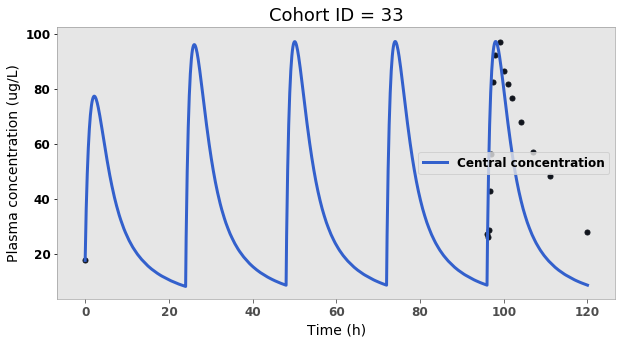

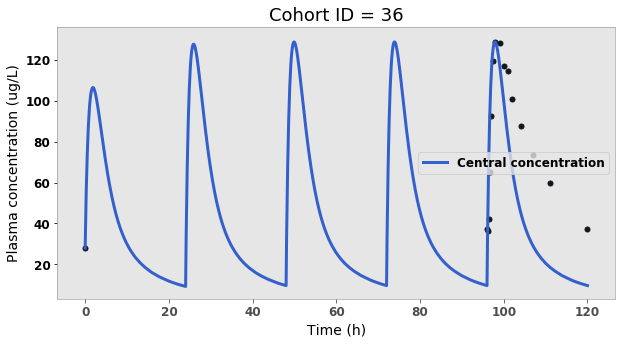

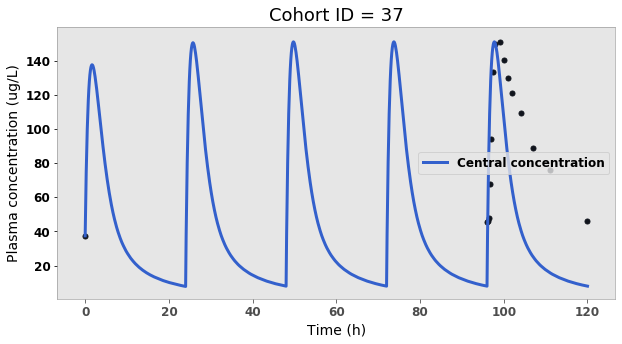

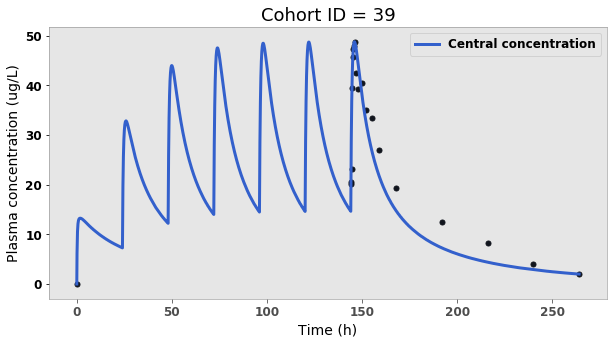

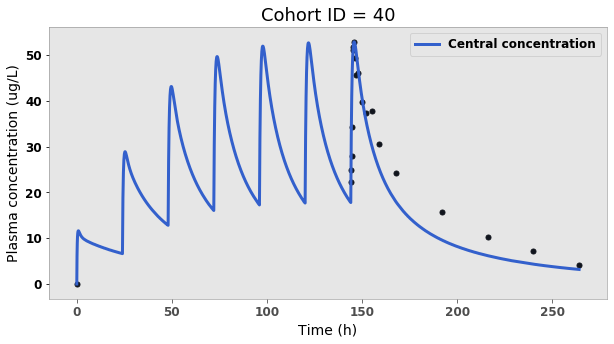

In [43]:
df_multi_fixed = format_de_dataframe(de_results_multi)
for subject_id in df_multi_fixed.subject_id.values:
    k_values = list(df_multi_fixed[df_multi.subject_id == subject_id][['Bmax_k12','k21','ke']].values[0])
    plot_best_fit(k_values, subject_id)

### Apply single dosing

3 map to 20, 6 map to 22, 7 map to 23, 15 map to 39, 16 map to 40

Central Cmax = 38.93880280163501, Peripheral Cmax = 10.181086578951387


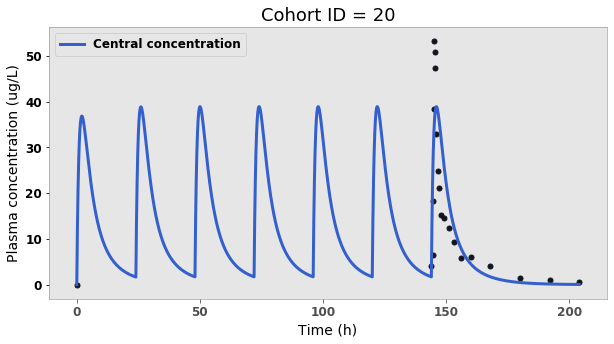

In [64]:
# Subject 20
subject_id = 20
k_values = [12.60989622, 0.84997925, 0.22251457] # From single dosing (Subject ID 3)
plot_best_fit(k_values, subject_id)

Central Cmax = 48.65408945880424, Peripheral Cmax = 30.05831808204323


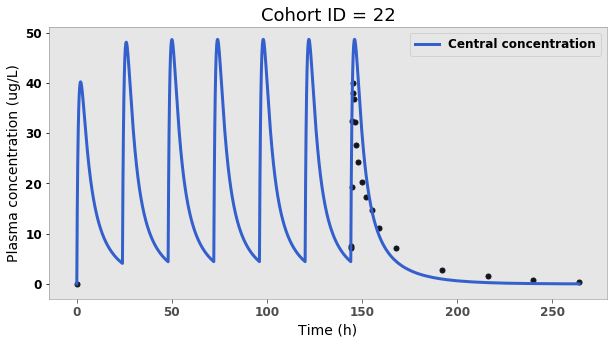

In [65]:
# Subject 22
subject_id = 22
k_values = [34.78024573, 0.85, 0.20873623] # From single dosing (Subject ID 6)
plot_best_fit(k_values, subject_id)

Central Cmax = 77.15870208485403, Peripheral Cmax = 42.381221711852994


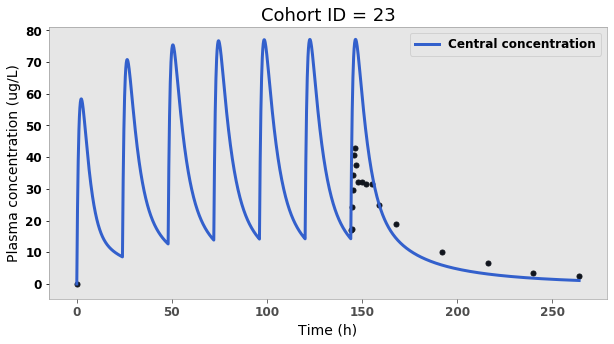

In [66]:
# Subject 23
subject_id = 23
k_values = [8.00097254, 0.13980983, 0.10196638] # From single dosing (Subject ID 7)
plot_best_fit(k_values, subject_id)

Central Cmax = 69.5297001106065, Peripheral Cmax = 41.46824925415364


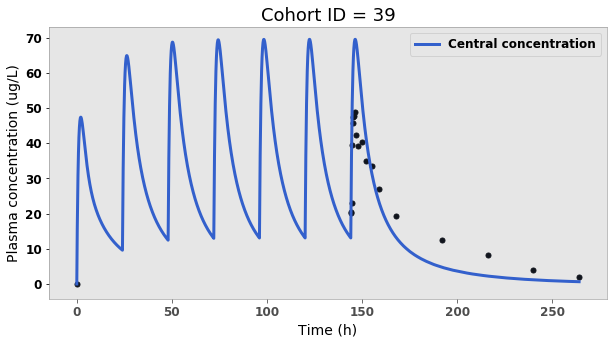

In [67]:
# Subject 39
subject_id = 39
k_values = [21.69242775, 0.40671031, 0.11341312] # From single dosing (Subject ID 15)
plot_best_fit(k_values, subject_id)

Central Cmax = 81.89664479752915, Peripheral Cmax = 51.61170897443


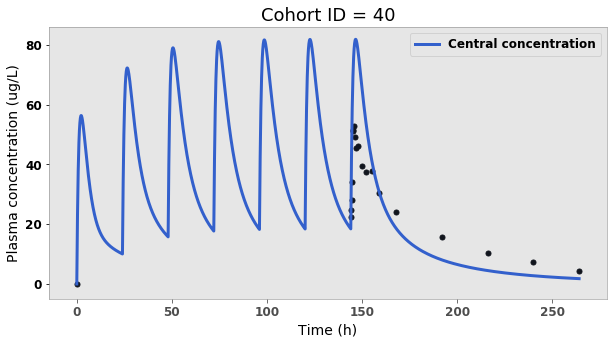

In [68]:
# Subject 40
subject_id = 40
k_values = [10.71821793,0.16022135,0.08930014] # From single dosing (Subject ID 16)
plot_best_fit(k_values, subject_id)